# Second Environment:
## Neural Network - Explicit Feedback with adding covariantes
_Mariem Kachouri & Dinara Veshchezerova_

In [1]:
import pandas as pd
import numpy as np
import gc
import requests 
from time import sleep
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline  

### Caling Reset Method to get Initial History Data

In [2]:
user_id = 'VWW01S0D18NSKR55Q43F'
base_url ='http://35.180.254.42/'
url_reset=base_url+"reset"
url_predict = base_url+'predict'
params = {'user_id':user_id}
r = requests.get(url=url_reset,params=params) # get history of rating
data = r.json()

In [3]:
data.keys()

dict_keys(['item_history', 'nb_items', 'user_history', 'next_variables', 'rating_history', 'variables_history', 'next_user', 'next_item', 'nb_users'])

In [4]:
## Retrieving usueful data & params for fitting
nb_users = data['nb_users'] # 100
nb_items = data['nb_items'] # 300
user_history = data['user_history']
item_history = data['item_history']
rating_history = data['rating_history']
variables_history = data['variables_history']

## Initial prediction
next_user = data['next_user']
next_item = data['next_item']
next_var = data['next_variables']

Ce sont des variables qui agissent comme des features et nous renseignant à la fois sur les users et les items par exemple dans le cas  d'un nouvel item qui n'a pas d'historique de ventes mais qui, en se basant sur les achats précédents de certains users, peuten intéresser certains.

In [5]:
print('Nb of covariantes: {}'.format(len(next_var)))

Nb of covariantes: 5


### Splitting dataset into training & test Sets

In [6]:
user_train, user_test, item_train, item_test, var_train,var_test, rating_train, rating_test = train_test_split(user_history,item_history, variables_history,rating_history, test_size=0.25, random_state=0)

## Putting the variables input sin the right dimensions
var_train = np.expand_dims(var_train, axis=1)
var_test = np.expand_dims(var_test, axis=1)

In [7]:
print("Shape User Training Set: %d" %len(user_train))
print('Shape User Training Set: {}'.format(var_train.shape))

Shape User Training Set: 1500
Shape User Training Set: (1500, 1, 5)


## Training the model with covariantes

In [8]:
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate,Dense, Dropout
from keras.models import Model

Using TensorFlow backend.


In [9]:
def create_model ( nb_users, nb_items, embedding_size =30 , fc1_units=20 , fc2_units = 20, dropout=0):
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    variable_input =Input(shape=[1,5],name='variable')

    
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                               input_length=1, name='user_embedding')(user_id_input)

    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                               input_length=1, name='item_embedding')(item_id_input)

    # reshape from shape: (batch_size, input_length, embedding_size)
    # to shape: (batch_size, input_length * embedding_size) which is
    # equal to shape: (batch_size, embedding_size)
    
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    variables_vecs = Flatten()(variable_input)
    

    # concatenate vectors
    item_user_vecs = Concatenate(axis=1)([user_vecs, item_vecs])
    final_vecs = Concatenate(axis=1)([variables_vecs,item_user_vecs])

    # Dropout %
    final_vecs = Dropout(dropout)(final_vecs)
    
    # Fully connected layers

    dense_layer1 = Dense(units = fc1_units , activation='relu')(final_vecs)
    dense_layer2 = Dense(units = fc2_units, activation='relu')(dense_layer1)
    dense_output = Dense(units = 1 , activation='relu')(dense_layer2)

    model = Model(inputs=[user_id_input, item_id_input,variable_input], outputs=dense_output)    
    return model

In [10]:
## Creating the model 
history_model = create_model(nb_users, nb_items, embedding_size=30, fc1_units=20, fc2_units=15, dropout=0.1)
history_model.compile(optimizer='adam', loss='MAE')

In [11]:
%%time
history = history_model.fit([user_train, item_train, var_train], 
                            rating_train,
                            batch_size=64, 
                            epochs=20, 
                            validation_split=0.2,
                            shuffle=True)

Train on 1200 samples, validate on 300 samples
Epoch 1/20
1200/1200 [==============================] - 1s 1ms/step - loss: 2.7457 - val_loss: 2.6234
Epoch 2/20
1200/1200 [==============================] - 0s 87us/step - loss: 2.3106 - val_loss: 2.1076
Epoch 3/20
1200/1200 [==============================] - 0s 83us/step - loss: 1.8039 - val_loss: 1.5630
Epoch 4/20
1200/1200 [==============================] - 0s 126us/step - loss: 1.3973 - val_loss: 1.2834
Epoch 5/20
1200/1200 [==============================] - 0s 92us/step - loss: 1.2366 - val_loss: 1.1821
Epoch 6/20
1200/1200 [==============================] - 0s 78us/step - loss: 1.0822 - val_loss: 1.0802
Epoch 7/20
1200/1200 [==============================] - 0s 122us/step - loss: 0.9330 - val_loss: 0.9708
Epoch 8/20
1200/1200 [==============================] - 0s 138us/step - loss: 0.7750 - val_loss: 0.8853
Epoch 9/20
1200/1200 [==============================] - 0s 233us/step - loss: 0.6754 - val_loss: 0.8208
Epoch 10/20
1200/1200 [

### Summarize history : Evolution of Training loss & Test Loss

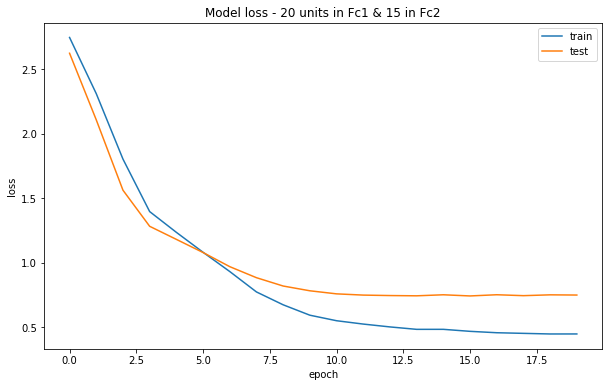

In [12]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - 20 units in Fc1 & 15 in Fc2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Computing predicitions on each next state

In [16]:
# Init
nb_samples = 1000
mse,mae = 0,0
mse_round, mae_round = 0,0

In [17]:
for i in range(nb_samples):
    sleep(0.05) 
    prediction =  history_model.predict([np.array(next_user).reshape(1,1), 
                                                         np.array(next_item).reshape(1,1), 
                                                         np.array(next_var).reshape(1,1,5)])[0][0]
    
    params['predicted_score'] = prediction 
    r=requests.get(url=url_predict,params=params)
    d=r.json()
    rating= d['rating'] # previous rating
    
    print('user: %s | item: %s | rating: %s | predicted rating: %s ' % (d['next_user'],d['next_item'],d['rating'],params['predicted_score']))
    
    next_user = d['next_user']
    next_item = d['next_item']
    
    mse+=(rating-prediction)**2
    mae+= abs(rating-prediction)
    
    mse_round+= (rating-round(prediction))**2
    mae_round+= abs(rating-round(prediction))

print('**')
print('Average MSE: ', mse/nb_samples)
print('Average MAE: ', mae/nb_samples)
print('**')
print('Average MSE with round: ', mse_round/nb_samples)
print('Average MAE with round : ', mae_round/nb_samples)

user: 10 | item: 125 | rating: 2 | predicted rating: 2.0577643 
user: 4 | item: 196 | rating: 1 | predicted rating: 1.0748622 
user: 4 | item: 85 | rating: 2 | predicted rating: 2.2089682 
user: 75 | item: 262 | rating: 2 | predicted rating: 2.140787 
user: 92 | item: 158 | rating: 5 | predicted rating: 4.912212 
user: 12 | item: 198 | rating: 3 | predicted rating: 3.637075 
user: 8 | item: 183 | rating: 3 | predicted rating: 2.4489758 
user: 37 | item: 154 | rating: 5 | predicted rating: 3.5965648 
user: 90 | item: 264 | rating: 3 | predicted rating: 1.8269923 
user: 62 | item: 83 | rating: 2 | predicted rating: 3.027916 
user: 61 | item: 185 | rating: 2 | predicted rating: 3.9953227 
user: 96 | item: 184 | rating: 2 | predicted rating: 2.9086623 
user: 55 | item: 113 | rating: 5 | predicted rating: 6.0424814 
user: 9 | item: 69 | rating: 3 | predicted rating: 3.3335993 
user: 21 | item: 209 | rating: 2 | predicted rating: 2.2356706 
user: 43 | item: 92 | rating: 2 | predicted rating:

user: 4 | item: 251 | rating: 2 | predicted rating: 2.1717904 
user: 65 | item: 215 | rating: 2 | predicted rating: 1.7167507 
user: 48 | item: 269 | rating: 3 | predicted rating: 3.1391706 
user: 37 | item: 191 | rating: 4 | predicted rating: 3.1416094 
user: 65 | item: 261 | rating: 4 | predicted rating: 4.175741 
user: 20 | item: 172 | rating: 1 | predicted rating: 1.9108748 
user: 37 | item: 25 | rating: 4 | predicted rating: 1.6009392 
user: 73 | item: 85 | rating: 1 | predicted rating: 1.8447945 
user: 19 | item: 290 | rating: 2 | predicted rating: 1.8427579 
user: 47 | item: 86 | rating: 2 | predicted rating: 1.9014629 
user: 81 | item: 233 | rating: 2 | predicted rating: 4.3318853 
user: 3 | item: 229 | rating: 4 | predicted rating: 4.0174656 
user: 70 | item: 240 | rating: 5 | predicted rating: 5.120752 
user: 24 | item: 16 | rating: 5 | predicted rating: 4.3566117 
user: 36 | item: 148 | rating: 3 | predicted rating: 3.5516644 
user: 32 | item: 31 | rating: 2 | predicted rati

user: 25 | item: 93 | rating: 3 | predicted rating: 1.9832085 
user: 54 | item: 267 | rating: 4 | predicted rating: 3.6580725 
user: 87 | item: 254 | rating: 4 | predicted rating: 4.8870974 
user: 75 | item: 219 | rating: 5 | predicted rating: 3.4002604 
user: 70 | item: 86 | rating: 3 | predicted rating: 3.356648 
user: 83 | item: 46 | rating: 2 | predicted rating: 4.3476787 
user: 12 | item: 119 | rating: 1 | predicted rating: 2.0711122 
user: 72 | item: 145 | rating: 5 | predicted rating: 4.7125993 
user: 20 | item: 174 | rating: 5 | predicted rating: 4.892512 
user: 52 | item: 10 | rating: 2 | predicted rating: 2.9591238 
user: 55 | item: 7 | rating: 5 | predicted rating: 4.7028284 
user: 77 | item: 287 | rating: 2 | predicted rating: 2.503192 
user: 56 | item: 4 | rating: 2 | predicted rating: 2.1529481 
user: 55 | item: 177 | rating: 4 | predicted rating: 3.2772796 
user: 51 | item: 42 | rating: 1 | predicted rating: 2.078233 
user: 54 | item: 244 | rating: 1 | predicted rating: 

user: 48 | item: 101 | rating: 5 | predicted rating: 4.7570086 
user: 95 | item: 277 | rating: 1 | predicted rating: 3.4735894 
user: 55 | item: 151 | rating: 3 | predicted rating: 3.106406 
user: 81 | item: 38 | rating: 2 | predicted rating: 3.0005345 
user: 16 | item: 5 | rating: 2 | predicted rating: 2.5466218 
user: 29 | item: 139 | rating: 4 | predicted rating: 3.6828601 
user: 17 | item: 74 | rating: 5 | predicted rating: 4.8802447 
user: 11 | item: 273 | rating: 1 | predicted rating: 1.8869379 
user: 38 | item: 285 | rating: 1 | predicted rating: 2.004508 
user: 8 | item: 252 | rating: 1 | predicted rating: 1.3502032 
user: 66 | item: 8 | rating: 2 | predicted rating: 2.053693 
user: 57 | item: 178 | rating: 1 | predicted rating: 3.9067888 
user: 2 | item: 261 | rating: 1 | predicted rating: 1.0287409 
user: 42 | item: 57 | rating: 4 | predicted rating: 4.0324144 
user: 50 | item: 2 | rating: 2 | predicted rating: 4.3090186 
user: 3 | item: 222 | rating: 1 | predicted rating: 0.

user: 42 | item: 50 | rating: 2 | predicted rating: 1.882542 
user: 64 | item: 189 | rating: 5 | predicted rating: 3.7764406 
user: 20 | item: 173 | rating: 5 | predicted rating: 5.0969305 
user: 57 | item: 173 | rating: 2 | predicted rating: 2.154198 
user: 16 | item: 285 | rating: 2 | predicted rating: 2.4881353 
user: 59 | item: 267 | rating: 2 | predicted rating: 2.4059436 
user: 7 | item: 116 | rating: 3 | predicted rating: 3.4616275 
user: 0 | item: 294 | rating: 2 | predicted rating: 2.6959798 
user: 2 | item: 98 | rating: 4 | predicted rating: 4.0940323 
user: 62 | item: 127 | rating: 5 | predicted rating: 5.3967566 
user: 60 | item: 111 | rating: 3 | predicted rating: 2.7391124 
user: 54 | item: 35 | rating: 1 | predicted rating: 1.8758001 
user: 53 | item: 171 | rating: 4 | predicted rating: 4.912289 
user: 55 | item: 280 | rating: 1 | predicted rating: 0.9346145 
user: 39 | item: 36 | rating: 1 | predicted rating: 1.6681372 
user: 28 | item: 285 | rating: 3 | predicted ratin

user: 88 | item: 67 | rating: 2 | predicted rating: 4.946308 
user: 70 | item: 16 | rating: 1 | predicted rating: 1.8777279 
user: 33 | item: 211 | rating: 2 | predicted rating: 2.825337 
user: 59 | item: 270 | rating: 2 | predicted rating: 2.1362782 
user: 59 | item: 56 | rating: 4 | predicted rating: 3.4050612 
user: 6 | item: 225 | rating: 2 | predicted rating: 2.1628668 
user: 74 | item: 158 | rating: 3 | predicted rating: 3.4630477 
user: 45 | item: 248 | rating: 2 | predicted rating: 3.2180698 
user: 2 | item: 58 | rating: 5 | predicted rating: 4.49844 
user: 39 | item: 291 | rating: 5 | predicted rating: 4.631779 
user: 93 | item: 292 | rating: 3 | predicted rating: 2.0601447 
user: 68 | item: 152 | rating: 2 | predicted rating: 1.5155696 
user: 14 | item: 138 | rating: 3 | predicted rating: 3.077671 
user: 70 | item: 260 | rating: 5 | predicted rating: 3.9021032 
user: 13 | item: 198 | rating: 3 | predicted rating: 4.5124636 
user: 42 | item: 54 | rating: 1 | predicted rating: 

user: 2 | item: 235 | rating: 4 | predicted rating: 4.1668186 
user: 94 | item: 169 | rating: 5 | predicted rating: 4.9328094 
user: 3 | item: 59 | rating: 2 | predicted rating: 2.9534266 
user: 10 | item: 4 | rating: 5 | predicted rating: 5.4731045 
user: 98 | item: 293 | rating: 1 | predicted rating: 1.4770235 
user: 72 | item: 150 | rating: 5 | predicted rating: 4.874882 
user: 28 | item: 244 | rating: 5 | predicted rating: 4.379179 
user: 90 | item: 150 | rating: 2 | predicted rating: 2.4820771 
user: 89 | item: 118 | rating: 1 | predicted rating: 2.8564591 
user: 0 | item: 32 | rating: 3 | predicted rating: 2.3668616 
user: 44 | item: 51 | rating: 3 | predicted rating: 2.968371 
user: 69 | item: 74 | rating: 5 | predicted rating: 5.5877256 
user: 30 | item: 217 | rating: 1 | predicted rating: 2.2495415 
user: 86 | item: 87 | rating: 4 | predicted rating: 3.8159547 
user: 67 | item: 64 | rating: 4 | predicted rating: 3.8670468 
user: 28 | item: 295 | rating: 4 | predicted rating: 4

user: 92 | item: 16 | rating: 4 | predicted rating: 2.3715534 
user: 37 | item: 135 | rating: 2 | predicted rating: 2.1106734 
user: 58 | item: 99 | rating: 4 | predicted rating: 3.6131897 
user: 45 | item: 149 | rating: 3 | predicted rating: 1.8758394 
user: 54 | item: 240 | rating: 2 | predicted rating: 1.6892425 
user: 95 | item: 16 | rating: 4 | predicted rating: 4.4762297 
user: 68 | item: 252 | rating: 3 | predicted rating: 2.6668131 
user: 87 | item: 47 | rating: 1 | predicted rating: 1.8574191 
user: 3 | item: 159 | rating: 3 | predicted rating: 2.499039 
user: 26 | item: 221 | rating: 5 | predicted rating: 3.3482296 
user: 61 | item: 39 | rating: 5 | predicted rating: 4.036115 
user: 54 | item: 175 | rating: 3 | predicted rating: 3.5180118 
user: 90 | item: 100 | rating: 4 | predicted rating: 4.7356334 
user: 89 | item: 96 | rating: 2 | predicted rating: 2.4617612 
user: 0 | item: 263 | rating: 3 | predicted rating: 2.492543 
user: 98 | item: 238 | rating: 3 | predicted rating

__Interprétation:__<br>
En essayant de faire un arrondi sur les prédictions pvu que ce sont des entiers et représentent des scores de 1 à 5, on remarque que la MSE est plus élevée que dans le cas où on laisse les prédicitons sous forme de float. En effet, ceci est dû au fait que sur l'arrondi l'erreur au carré deviendra plus importante dans le cas où par exmeple on prédit 2.48 et que l'arrondi donne 2 alors que la vrai valeur du score est de 4 donc on aura 2 au carré au niveau de la MSE. <br> 
Néanmoins, la MAE est moins importante et comme le modèle a été compilé pour minimiser la MAE lorsqu'on avait défini la Loss, il est judicieux de garder ce critère pour l'évaluation du modèle.